In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd
from prophet import Prophet
import pandas as pd 
orig_df = pd.read_csv("resource/kz.csv")

In [28]:
sales_df = orig_df.copy()
sales_df['event_time'] = sales_df['event_time'].apply(lambda x: x.replace("UTC", ""))
#sales_stripped_df = pd.DataFrame(sales_df, columns = ['event_time','order_id'], index = ['event_time'])
sales_df['event_time'] = pd.to_datetime(sales_df['event_time'])
sales_df_stripped = sales_df[[ 'event_time', 'order_id']]
sales_df_stripped_per_hr = sales_df_stripped.groupby(pd.Grouper(key='event_time', axis=0, freq='H')).count()
sales_df_stripped_per_hr = sales_df_stripped_per_hr.loc['2020-11-01':'2021-12-31'].loc[sales_df_stripped_per_hr['order_id'] > 0]
sales_df_stripped_per_hr = sales_df_stripped_per_hr.loc[sales_df_stripped_per_hr['order_id'] > 100]
sales_df_stripped_per_hr.dropna(inplace=True)

In [29]:
sales_df_stripped_per_hr.tail()         

,order_id
event_time,
2021-11-19 11:00:00,982
2021-11-19 12:00:00,1026
2021-11-19 13:00:00,747
2021-11-19 14:00:00,380
2021-11-19 15:00:00,157


In [30]:
sales_df_stripped_per_hr.reset_index(inplace=True)
sales_df_stripped_per_hr.columns = ['ds', 'y']

In [31]:

sales_df_stripped_per_hr.describe()

,y
count,3460.000000
mean,727.183237
std,570.901857
min,101.000000
25%,255.000000
50%,557.500000
75%,1092.500000
max,2835.000000


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(sales_df_stripped_per_hr, test_size=0.3, shuffle=False)

In [33]:
df_train = X_train.copy()
df_train.sort_index(inplace=True)
print(X_test.tail())
print(X_train.tail())

                      ds     y
3455 2021-11-19 11:00:00   982
3456 2021-11-19 12:00:00  1026
3457 2021-11-19 13:00:00   747
3458 2021-11-19 14:00:00   380
3459 2021-11-19 15:00:00   157
                      ds    y
2417 2021-08-11 05:00:00  458
2418 2021-08-11 06:00:00  581
2419 2021-08-11 07:00:00  586
2420 2021-08-11 08:00:00  568
2421 2021-08-11 09:00:00  633


In [34]:
len(X_test)

1038

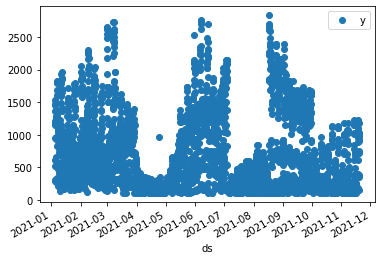

In [35]:
# current order trend is a linear function with seasonality
from matplotlib import pyplot
sales_df_stripped_per_hr.plot(x='ds', y='y', style='o')
pyplot.show() 

In [50]:
#m = Prophet('growth= 'logistic)
m = Prophet(growth='linear',weekly_seasonality='auto',daily_seasonality=True,yearly_seasonality=True)
#m.add_seasonality('self_define_cycle',period=1,fourier_order=8,mode='additive')
#m.add_seasonality(name='daily', period=12, fourier_order=5)
m.add_country_holidays(country_name='US')
m.fit(df_train)
# simple model to start with. we can interact with the model to change the parameters e.g logistic growth
# try other timeseries models starting ARIMA, variatios in prophet, etc

In [51]:
future = m.make_future_dataframe(periods=len(X_test)+24,freq='H')
future_dates = pd.merge(future, (df_train.append(X_test)).drop('y', axis=1), on = 'ds')
future_dates.tail()

,ds
2953,2021-09-24 11:00:00
2954,2021-09-24 12:00:00
2955,2021-09-24 13:00:00
2956,2021-09-24 14:00:00
2957,2021-09-24 15:00:00


In [52]:
future['cap'] = 2000 # set the cap to 20k
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2953,2021-09-24 11:00:00,1011.361642,565.697975,1454.975124
2954,2021-09-24 12:00:00,850.153044,428.512607,1292.022005
2955,2021-09-24 13:00:00,587.858841,135.057043,1017.343246
2956,2021-09-24 14:00:00,351.849417,-47.337793,776.916876
2957,2021-09-24 15:00:00,266.383083,-179.192796,692.608717


<ipython-input-53-9356221cd325>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Text(0.5, 33.0, 'Date')

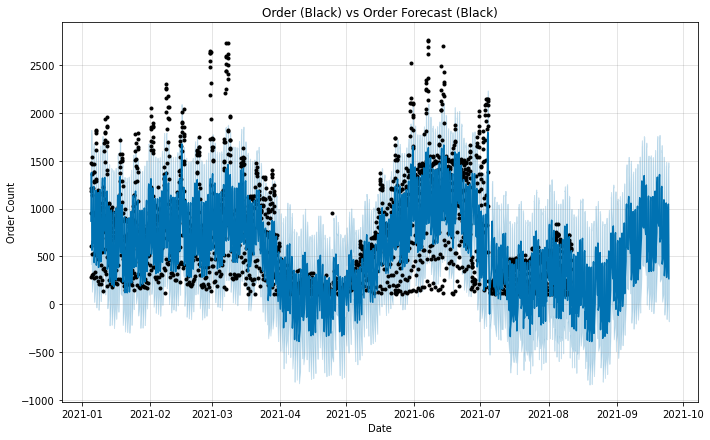

In [53]:
import matplotlib.pyplot as plt
fig1 = m.plot(forecast)
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_title('Order (Black) vs Order Forecast (Black)')
ax1.set_ylabel('Order Count')
ax1.set_xlabel('Date')

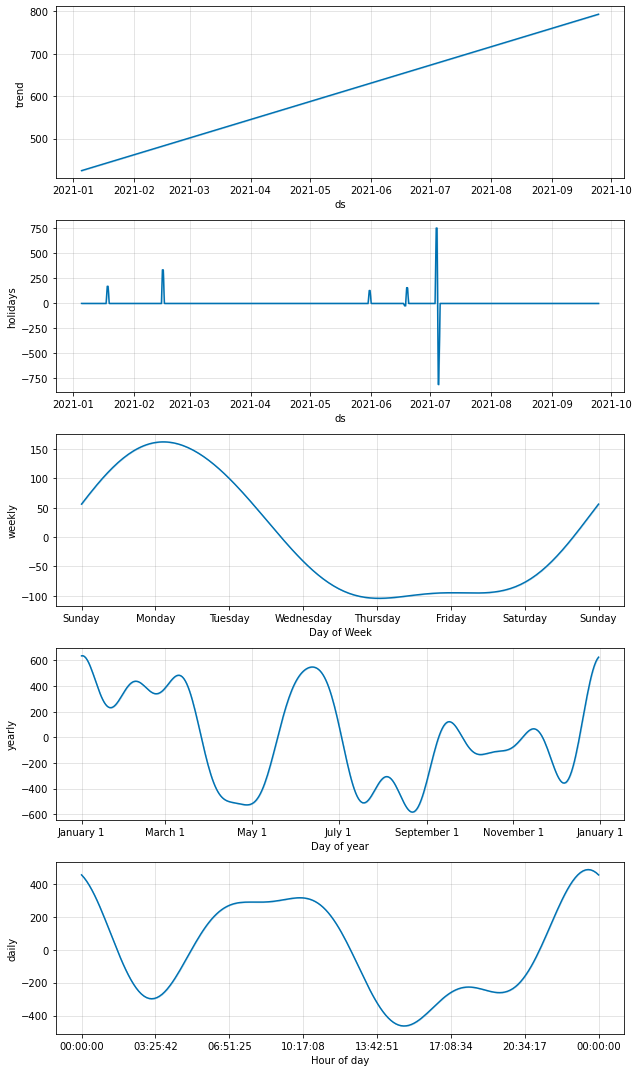

In [54]:
fig2 = m.plot_components(forecast)

In [55]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [56]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [57]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = sales_df_stripped_per_hr['ds'].values
y_prophet['y'] = sales_df_stripped_per_hr['y'].values
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [58]:
y_prophet.tail()

,y
ds,
2021-11-19 11:00:00,982
2021-11-19 12:00:00,1026
2021-11-19 13:00:00,747
2021-11-19 14:00:00,380
2021-11-19 15:00:00,157


In [59]:
forecast_prophet.tail(5)
#forecast.tail(5)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2021-09-24 11:00:00,792.965114,565.697975,1454.975124,792.965075,792.965160,0.0,0.0,0.0,0.0,0.0,...,-94.958783,-94.958783,-94.958783,32.799570,32.799570,32.799570,0.0,0.0,0.0,1011.361642
2021-09-24 12:00:00,793.023620,428.512607,1292.022005,793.023581,793.023667,0.0,0.0,0.0,0.0,0.0,...,-94.660066,-94.660066,-94.660066,32.009995,32.009995,32.009995,0.0,0.0,0.0,850.153044
2021-09-24 13:00:00,793.082126,135.057043,1017.343246,793.082087,793.082173,0.0,0.0,0.0,0.0,0.0,...,-94.240129,-94.240129,-94.240129,31.219463,31.219463,31.219463,0.0,0.0,0.0,587.858841
2021-09-24 14:00:00,793.140633,-47.337793,776.916876,793.140593,793.140679,0.0,0.0,0.0,0.0,0.0,...,-93.682004,-93.682004,-93.682004,30.428010,30.428010,30.428010,0.0,0.0,0.0,351.849417
2021-09-24 15:00:00,793.199139,-179.192796,692.608717,793.199099,793.199185,0.0,0.0,0.0,0.0,0.0,...,-92.969006,-92.969006,-92.969006,29.635674,29.635674,29.635674,0.0,0.0,0.0,266.383083


In [60]:
evaluate_forecast(y_prophet.y[10:100], forecast_prophet.yhat[10:100])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.57705,272.796229,245.323063,109375.812847,0.182584,0.414912,330.720143


In [61]:
from sqlalchemy import create_engine
from config import POSTGRES_ADDRESS, POSTGRES_USERNAME, POSTGRES_PASSWORD, POSTGRES_DBNAME ,POSTGRES_PORT
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
 .format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))


In [62]:
cnx = create_engine(postgres_str)

In [24]:
## persist the model in PG
# saving to database so that mico batch will scan and scale up and scale down instances
postgres_df = pd.DataFrame(forecast_prophet[['yhat','yhat_lower','yhat_upper']]).copy()
postgres_df.reset_index(inplace=True)
postgres_df[['ds','yhat','yhat_lower','yhat_upper']]
postgres_df.to_sql('oph_forecast1', cnx, if_exists='append', index=False)
cnx.dispose()